In [1]:
# 필요 패키지 import
import math
import requests

import PIL
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, SegformerConfig

import warnings
warnings.filterwarnings('ignore')

2024-07-28 11:23:16.123633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-28 11:23:16.198624: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-28 11:23:16.604719: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2024-07-28 11:23:16.604771: W tensorflow/compiler/xl

In [3]:
# Load image processor and pretrained_models
model_name = "nvidia/segformer-b0-finetuned-cityscapes-768-768" #"nvidia/segformer-b0-finetuned-ade-512-512"

image_processor = SegformerImageProcessor.from_pretrained(model_name) ## 이미지 전처리기
model = SegformerForSemanticSegmentation.from_pretrained(model_name) ## segformer 모델

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

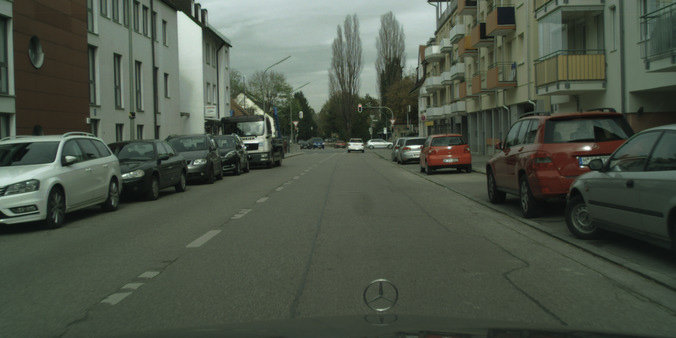

In [4]:
# Load image
url = "https://cdn-media.huggingface.co/Inference-API/Sample-results-on-the-Cityscapes-dataset-The-above-images-show-how-our-method-can-handle.png" #"http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [5]:
inputs = image_processor(images=image, return_tensors="pt")
inputs['pixel_values'].shape # shape (batch_size, num_channel, height, width)

torch.Size([1, 3, 512, 512])

In [6]:
# Inference
outputs = model(**inputs)
logits = outputs.logits
logits.shape  # shape (batch_size, num_labels, height/4, width/4)

torch.Size([1, 19, 128, 128])

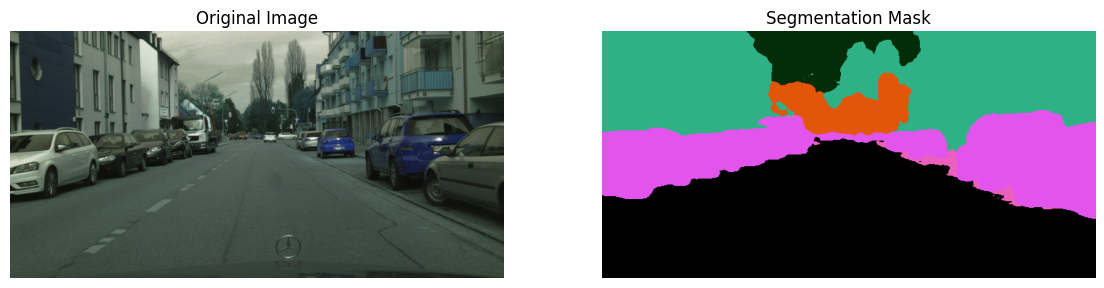

In [8]:
# visualize
height, width = image.height, image.width

resized_logits = F.interpolate(logits, size=(height, width), mode='bilinear') # 원본 이미지 크기에 맞게 mask resize
num_classes = resized_logits.shape[1]

colors = np.random.randint(0, 255, size=(num_classes - 1, 3))
colors = np.vstack([[0, 0, 0], colors]).astype('uint8') # visualize를 위한 mask color 정의

classmap = resized_logits.argmax(dim=1) # 가장 높은 confidence score를 가진 class의 인덱스 추출

original_image = np.array(image)
predicted_mask = colors[classmap[0]] # 해당 클래스마다 정의한 color 매칭

# 원본 이미지와 예측 mask 결과 시각화
fig = plt.figure(figsize = (14, 12))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(original_image[...,::-1])
ax1.set_title('Original Image')
ax1.axis('off')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(predicted_mask)
ax2.set_title('Segmentation Mask')
ax2.axis('off')

plt.show()

In [9]:
# 학습에 사용될 데이터셋을 불러옵니다
train_ds = load_dataset("scene_parse_150", split="train[:50]") ## 50개의 데이터 샘플만 가져오기

# 데이터 예시 확인
train_ds[0]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225>,
 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=L size=300x225>,
 'scene_category': 624}

In [10]:
# Dataset 클래스 정의
class CustomDataset(Dataset):
  def __init__(self, ds):
    self.ds = ds

  def __len__(self):
    return len(self.ds)

  def __getitem__(self, idx):
    data = self.ds[idx]
    img = image_processor(images=data['image'], return_tensors="pt")['pixel_values'][0] # image tensor

    _, height, width = img.shape
    label = data['annotation'].resize((width, height), resample=PIL.Image.NEAREST)
    label = torch.from_numpy(np.array(label)).type(torch.int64)

    return img, label

In [11]:
# 데이터셋 및 데이터로더 정의
train_dataset = CustomDataset(train_ds)
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)


In [12]:
# 해당 데이터셋 클래스 개수에 맞게 정의
config = SegformerConfig()
config.num_labels = 151
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SegformerForSemanticSegmentation(config)
model = model.to(device)

In [13]:
# 필요한 hyperparameter 정의
criterion = nn.CrossEntropyLoss()
lr = 0.001
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [14]:
losses = []

for epoc in range(epochs):
  model.train()
  train_loss = 0
  for imgs, labels in tqdm(train_dl, desc=f'Epoc : {epoc}'):
    imgs = torch.tensor(imgs, device=device, dtype=torch.float32)
    labels = torch.tensor(labels, device=device, dtype=torch.long)

    model.zero_grad()
    preds = model(imgs).logits
    upsampled_logits = nn.functional.interpolate(
                preds, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )
    loss = criterion(upsampled_logits, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_dl)
  losses.append(train_loss)
  print(f'Train Loss:{train_loss:.3f}')


Epoc : 0: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


Train Loss:4.592


Epoc : 1: 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Train Loss:3.694


Epoc : 2: 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Train Loss:3.317


Epoc : 3: 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Train Loss:3.104


Epoc : 4: 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Train Loss:3.088


Epoc : 5: 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Train Loss:2.905


Epoc : 6: 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Train Loss:2.993


Epoc : 7: 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Train Loss:2.877


Epoc : 8: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Train Loss:2.777


Epoc : 9: 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]

Train Loss:2.906


In [15]:
config = SegformerConfig() # Segformer에 대한 config 선언

In [16]:
class SegformerOverlapPatchEmbeddings(nn.Module):
    """Construct the overlapping patch embeddings."""

    def __init__(self, patch_size, stride, num_channels, hidden_size):
        super().__init__()

        ## 이미지를 overlap 패치로 분할 + projection
        self.proj = nn.Conv2d(
            num_channels,
            hidden_size,
            kernel_size=patch_size,
            stride=stride,
            padding=patch_size // 2,
        )

        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, pixel_values):
        embeddings = self.proj(pixel_values) # (B, hidden_size, H/4, W/4)
        _, _, height, width = embeddings.shape

        embeddings = embeddings.flatten(2).transpose(1, 2) # (B, hidden_size, H/4, W/4) -> (B, hidden_size, HW/16) -> (B, HW/16, hidden_size)
        embeddings = self.layer_norm(embeddings)

        return embeddings, height, width

In [17]:
x = torch.randn(1, 3, 512, 512) # (B, C, H, W) | 입력 이미지 예시

# MiT-b0에서 첫번째 block에 대한 config
ope = SegformerOverlapPatchEmbeddings(
    patch_size=7,
    stride=4,
    num_channels=3,
    hidden_size=32,
)
embeddings, height, width = ope(x)

print(f"입력 이미지 : {list(x.shape)}")
print(f"Overlap Patch Embedding 후 높이 및 너비 : {height, width}")
print(f"Overlap Patch Embedding 후 embedding: {list(embeddings.shape)}") # (B, C, H, W) -> (B, HW/16, hidden_size)

입력 이미지 : [1, 3, 512, 512]
Overlap Patch Embedding 후 높이 및 너비 : (128, 128)
Overlap Patch Embedding 후 embedding: [1, 16384, 32]


In [18]:
# MiT-b0에서 첫번째 block에 대한 config

hidden_size = 32              # config.hidden_sizes[0]
num_attention_heads = 1       # config.num_attention_heads[0]
sequence_reduction_ratio = 8  # config.sr_ratios[0]

attention_head_size = int(hidden_size / num_attention_heads)
all_head_size = num_attention_heads * hidden_size

In [19]:
hidden_states = embeddings # (B, HW, hidden_size) overlap patch embedding을 통해 얻은 텐서

# Q, K, V 선언
query_layer = nn.Linear(hidden_size, all_head_size)
key_layer = nn.Linear(hidden_size, all_head_size)
value_layer = nn.Linear(hidden_size, all_head_size)

In [20]:
# Convolution 연산을 통해 efficient self-attention 구현
sr = nn.Conv2d(hidden_size, hidden_size, kernel_size=sequence_reduction_ratio, stride=sequence_reduction_ratio)

In [21]:
# (B, HW, hidden_size)의 텐서에서 attention score를 구하기 위하여 (B, num_attention_heads, HW, attention_head_size) 형태로 reshape
def transpose_for_scores(hidden_states):
    # (B, HW, hidden_size) -> (B, HW, num_attention_heads, attention_head_size)
    new_shape = hidden_states.size()[:-1] + (num_attention_heads, attention_head_size)
    hidden_states = hidden_states.view(new_shape)

    #(B, HW, num_attention_heads, attention_head_size) -> (B, num_attention_heads, HW, attention_head_size)
    return hidden_states.permute(0, 2, 1, 3)

In [22]:
# Query는 reduction 되기 전 hidden state로 계산
print(hidden_states.shape)
q = transpose_for_scores(query_layer(hidden_states))
q.shape # (B, num_attention_heads, HW, attention_head_size)

torch.Size([1, 16384, 32])


torch.Size([1, 1, 16384, 32])

In [23]:
batch_size, seq_len, num_channels = hidden_states.shape
batch_size, seq_len, num_channels

(1, 16384, 32)

In [24]:
# Convolution연산을 위해 (B, HW, hidden_size)를 (B, hidden_size, H, W) 형태로 reshape
#(B, HW, hidden_size) -> (B, hidden_size, HW) -> (B, hidden_size, H, W)
hidden_states = hidden_states.permute(0, 2, 1).reshape(batch_size, num_channels, height, width)
hidden_states.shape

torch.Size([1, 32, 128, 128])

In [25]:
hidden_states = sr(hidden_states)
hidden_states.shape # (B, hidden_size, H, W) -> (B, hidden_size, H/R, W/R)

torch.Size([1, 32, 16, 16])

In [26]:
# 다시 key, value와 연산되도록 reshape 및 permute
# (B, hidden_size, H/R, W/R) -> (B, hidden_size, H*W/(R*R)) -> (B, H*W/(R*R), hidden_size)
hidden_states = hidden_states.reshape(batch_size, num_channels, -1).permute(0, 2, 1)
hidden_states.shape

torch.Size([1, 256, 32])

In [27]:
k = transpose_for_scores(key_layer(hidden_states))
v = transpose_for_scores(value_layer(hidden_states))
k.shape, v.shape # (B, num_attention_heads, H*W/(R*R), attention_head_size)

(torch.Size([1, 1, 256, 32]), torch.Size([1, 1, 256, 32]))

In [28]:
# Module 전체 코드
class SegformerEfficientSelfAttention(nn.Module):
    """SegFormer's efficient self-attention mechanism. Employs the sequence reduction process introduced in the [PvT
    paper](https://arxiv.org/abs/2102.12122)."""

    def __init__(self, config, hidden_size, num_attention_heads, sequence_reduction_ratio):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads

        self.attention_head_size = int(self.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query_layer = nn.Linear(self.hidden_size, self.all_head_size)
        self.key_layer = nn.Linear(self.hidden_size, self.all_head_size)
        self.value_layer = nn.Linear(self.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        self.sr_ratio = sequence_reduction_ratio
        self.sr = nn.Conv2d(
            hidden_size, hidden_size, kernel_size=sequence_reduction_ratio, stride=sequence_reduction_ratio
        )
        self.layer_norm = nn.LayerNorm(hidden_size)

    # attention score를 구하기 위하여 (B, num_attention_heads, HW, attention_head_size) 형태로 reshape
    def transpose_for_scores(self, hidden_states):
        new_shape = hidden_states.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        hidden_states = hidden_states.view(new_shape)
        return hidden_states.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        height,
        width,
        output_attentions=False,
    ):
        q = self.transpose_for_scores(self.query_layer(hidden_states))

        if self.sr_ratio > 1:
            batch_size, seq_len, num_channels = hidden_states.shape
            # Convolution연산을 위해 (B, HW, hidden_size)를 (B, hidden_size, H, W) 형태로 reshape
            hidden_states = hidden_states.permute(0, 2, 1).reshape(batch_size, num_channels, height, width)

            # 해당 연산을 통해 sequence reduction 수행
            hidden_states = self.sr(hidden_states)

            # 다시 Key, Value와 연산되도록 reshape 및 permute
            hidden_states = hidden_states.reshape(batch_size, num_channels, -1).permute(0, 2, 1)
            hidden_states = self.layer_norm(hidden_states)

        k = self.transpose_for_scores(self.key_layer(hidden_states))
        v = self.transpose_for_scores(self.value_layer(hidden_states))

        # Attention score 구하기
        attention_scores = torch.matmul(q, k.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        context = torch.matmul(attention_probs, v)

        context = context.permute(0, 2, 1, 3).contiguous()
        new_context_shape = context.size()[:-2] + (self.all_head_size,)
        context = context.view(new_context_shape)

        outputs = (context, attention_probs) if output_attentions else (context,)

        return outputs

In [29]:
eff_sa = SegformerEfficientSelfAttention(config, hidden_size, num_attention_heads, sequence_reduction_ratio)

In [30]:
hidden_states = embeddings # (B, H*W, hidden_size) overlapped patch merging을 통해 얻은 텐서

slef_attention_output = eff_sa(hidden_states, height, width)
attention_output = slef_attention_output[0]
attention_output.shape

torch.Size([1, 16384, 32])

In [31]:
# Depth-wise 3x3 conv module
class SegformerDWConv(nn.Module):
    """"""
    def __init__(self, dim=768):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, hidden_states, height, width):
        batch_size, seq_len, num_channels = hidden_states.shape
        '''
        # tensor shape
        '''
        # (B, seq_len(=H*W), num_channels(=dim)) -> (B, num_channels, seq_len) -> (B, num_channels, H, W)
        hidden_states = hidden_states.transpose(1, 2).view(batch_size, num_channels, height, width) # (B, num_channels, H, W)
        hidden_states = self.dwconv(hidden_states)                                                  # (B, num_channels, H, W)
        '''
        # tensor shape
        '''
        hidden_states = hidden_states.flatten(2).transpose(1, 2)                                    # (B, num_channels, H*W) -> (B, H*W, num_channels)

        return hidden_states

In [32]:
class SegformerMixFFN(nn.Module):
    def __init__(self, config, in_features, hidden_features=None, out_features=None):
        super().__init__()
        out_features = out_features or in_features
        self.mlp1 = nn.Linear(in_features, hidden_features)
        self.dwconv = SegformerDWConv(hidden_features)
        self.intermediate_act_fn = nn.GELU()
        self.mlp2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, height, width):
        x_in = hidden_states
        hidden_states = self.mlp1(hidden_states)                  # MLP(x)
        hidden_states = self.dwconv(hidden_states, height, width) # Conv(MLP(x))
        hidden_states = self.intermediate_act_fn(hidden_states)   # GELU(Conv(MLP(x)))
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.mlp2(hidden_states)                  # MLP(GELU(Conv(MLP(x))))
        hidden_states = self.dropout(hidden_states)

        return hidden_states + x_in                               # MLP(GELU(Conv(MLP(x)))) + x

In [33]:
# MiT-b0에서 첫번째 block에 대한 config
mlp_ratio = 4      # config.mlp_ratios[0]
hidden_size = 32   # config.hidden_sizes[0]
mlp_hidden_size = int(hidden_size * mlp_ratio)

In [34]:
layer_norm_2 = nn.LayerNorm(hidden_size)
mixffn = SegformerMixFFN(config, in_features=hidden_size, hidden_features=mlp_hidden_size)

layer_output = mixffn(attention_output, height, width)
layer_output.shape

torch.Size([1, 16384, 32])

In [35]:
# Segformer attention module
class SegformerAttention(nn.Module):
    def __init__(self, config, hidden_size, num_attention_heads, sequence_reduction_ratio):
        super().__init__()
        self.eff_sa = SegformerEfficientSelfAttention(
            config=config,
            hidden_size=hidden_size,
            num_attention_heads=num_attention_heads,
            sequence_reduction_ratio=sequence_reduction_ratio,
        )
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout =  nn.Dropout(config.hidden_dropout_prob)
        self.output = nn.Sequential(self.dense, self.dropout)

    def forward(self, hidden_states, height, width, output_attentions=False):
        self_outputs = self.eff_sa(hidden_states, height, width, output_attentions)

        attention_output = self.output(self_outputs[0])
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs

In [36]:
# Segformer Block Module
class SegformerLayer(nn.Module):
    """This corresponds to the Block class in the original implementation."""

    def __init__(self, config, hidden_size, num_attention_heads, sequence_reduction_ratio, mlp_ratio):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(hidden_size)
        self.attention = SegformerAttention(
            config,
            hidden_size=hidden_size,
            num_attention_heads=num_attention_heads,
            sequence_reduction_ratio=sequence_reduction_ratio,
        )
        self.layer_norm_2 = nn.LayerNorm(hidden_size)
        mlp_hidden_size = int(hidden_size * mlp_ratio)
        self.mix_ffn = SegformerMixFFN(config, in_features=hidden_size, hidden_features=mlp_hidden_size)

    def forward(self, hidden_states, height, width, output_attentions=False):
        # Efficient Self-Attention
        self_attention_outputs = self.attention(
            self.layer_norm_1(hidden_states),  # in Segformer, layernorm is applied before self-attention
            height,
            width,
            output_attentions=output_attentions,
        )

        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        # First residual connection
        hidden_states = attention_output + hidden_states

        # Second residual connection
        # Mix-FFN
        layer_output = self.mix_ffn(self.layer_norm_2(hidden_states), height, width)

        outputs = (layer_output,) + outputs

        return outputs

In [37]:
# Segformer Encoder Module
class SegformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # patch embeddings
        channels = [config.num_channels, *config.hidden_sizes]
        self.patch_embeddings = nn.ModuleList([SegformerOverlapPatchEmbeddings(p, s, c, h) for p, s, c, h
                                               in zip(config.patch_sizes, config.strides, channels, config.hidden_sizes)])

        # Transformer blocks
        blocks = []
        for i in range(config.num_encoder_blocks):
            layers = nn.ModuleList([
                                    SegformerLayer(config,
                                                  hidden_size=config.hidden_sizes[i],
                                                  num_attention_heads=config.num_attention_heads[i],
                                                  sequence_reduction_ratio=config.sr_ratios[i],
                                                  mlp_ratio=config.mlp_ratios[i],
                                                  )
                                    for _ in range(config.depths[i])])

            blocks.append(layers)

        self.block = nn.ModuleList(blocks)

        # Layer norms
        self.layer_norm = nn.ModuleList(
            [nn.LayerNorm(config.hidden_sizes[i]) for i in range(config.num_encoder_blocks)]
        )

    def forward(
        self,
        pixel_values,
        output_attentions=False,
        output_hidden_states=False,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        batch_size = pixel_values.shape[0]

        hidden_states = pixel_values
        for idx, x in enumerate(zip(self.patch_embeddings, self.block, self.layer_norm)):

            patch_embedding, block_layer, norm_layer = x
            # Overlapped Patch Embedding
            hidden_states, height, width = patch_embedding(hidden_states)

            # 4개의 Block 반복
            for i, blk in enumerate(block_layer):
                layer_outputs = blk(hidden_states, height, width, output_attentions) # Efficient Self-attention & Mix-FFN
                hidden_states = layer_outputs[0]
                if output_attentions:
                    all_self_attentions = all_self_attentions + (layer_outputs[1],)

            # third, apply layer norm
            hidden_states = norm_layer(hidden_states)

            # fourth, optionally reshape back to (batch_size, num_channels, height, width)
            if idx != len(self.patch_embeddings) - 1 or (
                idx == len(self.patch_embeddings) - 1 and self.config.reshape_last_stage
            ):
                hidden_states = hidden_states.reshape(batch_size, height, width, -1).permute(0, 3, 1, 2).contiguous()
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

        return hidden_states, all_hidden_states, all_self_attentions


In [38]:
encoder = SegformerEncoder(config)

In [39]:
x = torch.randn(1,3,512,512)
hidden_states, all_hidden_states, all_self_attentions = encoder(x, True, True)

print(f"입력 이미지 : {list(x.shape)}")
for i, states in enumerate(all_hidden_states):
  print(f"{i+1}번째 Block 후 Feature: {list(states.shape)}")

입력 이미지 : [1, 3, 512, 512]
1번째 Block 후 Feature: [1, 32, 128, 128]
2번째 Block 후 Feature: [1, 64, 64, 64]
3번째 Block 후 Feature: [1, 160, 32, 32]
4번째 Block 후 Feature: [1, 256, 16, 16]


In [40]:
class SegformerMLP(nn.Module):
    def __init__(self, config: SegformerConfig, input_dim):
        super().__init__()
        self.proj = nn.Linear(input_dim, config.decoder_hidden_size)

    def forward(self, hidden_states: torch.Tensor):
        hidden_states = hidden_states.flatten(2).transpose(1, 2)
        hidden_states = self.proj(hidden_states)
        return hidden_states

In [41]:
# 각 Encoder block의 hidden feature
h1, h2, h3, h4 = all_hidden_states

for i, states in enumerate(all_hidden_states):
  print(f"{i+1}번째 Block 후 Feature: {list(states.shape)}")

1번째 Block 후 Feature: [1, 32, 128, 128]
2번째 Block 후 Feature: [1, 64, 64, 64]
3번째 Block 후 Feature: [1, 160, 32, 32]
4번째 Block 후 Feature: [1, 256, 16, 16]


In [42]:
#config.hidden_sizes = [32, 64, 160, 256]
mlp1 = SegformerMLP(config, config.hidden_sizes[0])
mlp2 = SegformerMLP(config, config.hidden_sizes[1])
mlp3 = SegformerMLP(config, config.hidden_sizes[2])
mlp4 = SegformerMLP(config, config.hidden_sizes[3])

o1 = mlp1(h1) # (B, 32,  H/4,  W/4)  -> (B, HW/16, 256)
o2 = mlp2(h2) # (B, 64,  H/8,  W/8)  -> (B, HW/64, 256)
o3 = mlp3(h3) # (B, 160, H/16, W/16) -> (B, HW/256, 256)
o4 = mlp4(h4) # (B, 256, H/32, W/32) -> (B, HW/1024, 256)

# 채널 수 config.decoder_hidden_size(=256)로 통일된 것 확인
o1.shape, o2.shape, o3.shape, o4.shape

(torch.Size([1, 16384, 256]),
 torch.Size([1, 4096, 256]),
 torch.Size([1, 1024, 256]),
 torch.Size([1, 256, 256]))

In [43]:
outputs = []
size = (128, 128) # 원래 이미지 크기의 1/4
for output in [o1, o2, o3, o4]:
  height = width = int(math.sqrt(output.shape[1]))
  output = output.permute(0, 2, 1)                    # (B, seq_len, C(=256)) -> (B, C, seq_slen)
  output = output.reshape(1, -1, height, width)       # (B, C, seq_len) -> (B, C, H, W)

  # 원본 이미지 크기의 1/4로 upsampling
  output = nn.functional.interpolate(output, size=size, mode="bilinear", align_corners=False)
  outputs.append(output)

# (B, C, H/4, W/4)로 통일된 것 확인
for o in outputs:
  print(o.shape)

torch.Size([1, 256, 128, 128])
torch.Size([1, 256, 128, 128])
torch.Size([1, 256, 128, 128])
torch.Size([1, 256, 128, 128])


In [44]:
# 4개의 feature들을 concatenate 후 aggregation을 진행할 Convolution 모듈
linear_fuse = nn.Conv2d(
    in_channels=config.decoder_hidden_size * config.num_encoder_blocks,
    out_channels=config.decoder_hidden_size,
    kernel_size=1,
    bias=False,
)
batch_norm = nn.BatchNorm2d(config.decoder_hidden_size)
activation = nn.ReLU()
dropout = nn.Dropout(config.classifier_dropout_prob)

# 최종적으로 클래스 개수만큼 출력이 되도록 classifier 선언
classifier = nn.Conv2d(config.decoder_hidden_size, config.num_labels, kernel_size=1)

In [ ]:
concatenated_outputs = torch.cat(outputs, dim=1)
concatenated_outputs.shape # (B, 4C, H/4, W/4)

torch.Size([1, 1024, 128, 128])

In [ ]:
hidden_states = linear_fuse(concatenated_outputs)  # (B, 4C, H/4, W/4) -> (B, C, H/4, W/4)
hidden_states = batch_norm(hidden_states)
hidden_states = activation(hidden_states)
hidden_states = dropout(hidden_states)

logits = classifier(hidden_states)              # (B, C, H/4, W/4) -> (B, num_labels H/4, W/4)
logits.shape

torch.Size([1, 151, 128, 128])

In [ ]:
class SegformerDecodeHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        # linear layers which will unify the channel dimension of each of the encoder blocks to the same config.decoder_hidden_size
        mlps = []
        for i in range(config.num_encoder_blocks):
            mlp = SegformerMLP(config, input_dim=config.hidden_sizes[i])
            mlps.append(mlp)
        self.linear_c = nn.ModuleList(mlps)

        # the following 3 layers implement the ConvModule of the original implementation
        self.linear_fuse = nn.Conv2d(
            in_channels=config.decoder_hidden_size * config.num_encoder_blocks,
            out_channels=config.decoder_hidden_size,
            kernel_size=1,
            bias=False,
        )
        self.batch_norm = nn.BatchNorm2d(config.decoder_hidden_size)
        self.activation = nn.ReLU()

        self.dropout = nn.Dropout(config.classifier_dropout_prob)
        self.classifier = nn.Conv2d(config.decoder_hidden_size, config.num_labels, kernel_size=1)

        self.config = config

    def forward(self, encoder_hidden_states: torch.FloatTensor) -> torch.Tensor:
        batch_size = encoder_hidden_states[-1].shape[0]

        all_hidden_states = ()
        for encoder_hidden_state, mlp in zip(encoder_hidden_states, self.linear_c):
            if self.config.reshape_last_stage is False and encoder_hidden_state.ndim == 3:
                height = width = int(math.sqrt(encoder_hidden_state.shape[-1]))
                encoder_hidden_state = (
                    encoder_hidden_state.reshape(batch_size, height, width, -1).permute(0, 3, 1, 2).contiguous()
                )

            # unify channel dimension
            height, width = encoder_hidden_state.shape[2], encoder_hidden_state.shape[3]
            encoder_hidden_state = mlp(encoder_hidden_state)
            encoder_hidden_state = encoder_hidden_state.permute(0, 2, 1)
            encoder_hidden_state = encoder_hidden_state.reshape(batch_size, -1, height, width)
            # upsample
            encoder_hidden_state = nn.functional.interpolate(
                encoder_hidden_state, size=encoder_hidden_states[0].size()[2:], mode="bilinear", align_corners=False
            )
            all_hidden_states += (encoder_hidden_state,)

        hidden_states = self.linear_fuse(torch.cat(all_hidden_states[::-1], dim=1))
        hidden_states = self.batch_norm(hidden_states)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.dropout(hidden_states)

        # logits are of shape (B, num_labels, H/4, E/4)
        logits = self.classifier(hidden_states)

        return logits

In [ ]:
decoder = SegformerDecodeHead(config)
y = decoder(all_hidden_states)
y.shape # (batch_size, num_labels, height/4, width/4)

torch.Size([1, 151, 128, 128])

In [ ]:
class SegformerForSemanticSegmentation(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.segformer = SegformerEncoder(config)
    self.decode_head = SegformerDecodeHead(config)

  def forward(self, pixel_values, output_attentions=True, output_hidden_states=True):
    hidden_states, all_hidden_states, all_self_attentions = self.segformer(x, output_attentions, output_hidden_states)
    logits = self.decode_head(all_hidden_states)

    return logits


In [ ]:
segformer = SegformerForSemanticSegmentation(config)

x = torch.randn(1, 3, 512, 512)
y = segformer(x)

print(f"입력 이미지 : {list(x.shape)}") # (B, 3, H, W)
print(f"결과 이미지 : {list(y.shape)}") # (B, num_labels, H/4, W/4)


입력 이미지 : [1, 3, 512, 512]
결과 이미지 : [1, 151, 128, 128]
